# 1.背景整理・EDA

このデータセットは2021年頃の、電子製品を販売している企業の電子商取引配送についてのデータである、という前提情報が与えられています。
そこで、EC業界の市場規模や業界のトレンド、共通する課題などを調べていきます。このnotebookでは特にEDAパートに注力して、市場分析は補助的に扱っていきます。

### 1-1.市場分析

*   市場規模
  *   国内（B to C EC）：13 兆 9,997 億円（令和４年度 電子商取引に関する市場調査 報告書 経済産業省 より）https://www.meti.go.jp/press/2023/08/20230831002/20230831002-1.pdf
*   業界の近年のトレンドや共通する課題
  *   EC（電子商取引）化の進展で、宅配便の取扱個数は増加の一途にあり、2019年度の43億個から2035年度には88億個へ倍増する見込み（日本経済研究センター）
  https://www.jcer.or.jp/research-report/20201117-2.html

  *   物流の2024年問題：2024年4月から働き方改革関連法施行により時間外労働の上限（休日を除く年960時間）規制等が適用され、輸送能力が2030年には全国で35%の荷物が運べなくなる、可能性があると試算されている。（国土交通省）
  https://wwwtb.mlit.go.jp/tohoku/00001_00251.html

### 1-2.EDA(データプレパレーション)

ここでは簡単なEDA(データプレパレーション)を行い、与えられたデータにどのようなカラムがあるか、欠損値やデータ型など、概要を把握していきます。

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
#最大表示列数の指定（20列）
pd.set_option('display.max_columns', 20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


まず、データ読み込みを行います。今回は、各カラムの説明は以下のように与えられています。

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/E_commerce.csv')#パスを設定

ID:顧客の ID

Warehouse_block：A、B、C、D、Eのブロックに分かれた倉庫

Mode_of_Shipment：船舶、航空便、陸路の方法で商品を発送

Customer_care_calls：発送問い合わせの電話件数

Customer_rating：顧客からの評価、 1 が最低 (最悪)、5 が最高 (最高)

Cost_of_the_Product：製品のコスト (米ドル)

Prior_purchases：以前の購入回数

Product_importance：低、中、高のパラメータで製品を分類

Gender：性別

Discount_offered：特定の製品に対して提供される割引

Weight in gms：グラム単位の重量

Reached.on.Time_Y.N：ターゲット変数、1 は製品が時間通りに到着していないことを示し、0 は製品が時間通りに到着したことを示す

Restock_Frequency_Index：在庫補填の頻度の指標

Shipment_Frequency_Index：出荷の頻度の指標

各カラムの説明や、データの概要を確認し、目的変数の候補を確認します。また、目的変数候補と他の変数との関係を可視化、把握し、傾向を掴んでいきます。

In [ ]:
# データの確認
print(f"df shape: {df.shape}")
df

df shape: (10999, 14)


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Restock_Frequency_Index,Shipment_Frequency_Index
0,1,D,Flight,4,2,177,3,low,F,44,5335,1,0.034091,0.200000
1,2,F,Flight,4,2,216,2,low,M,59,2941,1,0.025424,0.200000
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,0.062500,0.333333
3,4,B,Flight,3,1,176,4,medium,M,10,1149,1,0.300000,0.250000
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,0.065217,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,2,252,5,medium,F,1,1014,1,6.000000,0.400000
10995,10996,B,Ship,4,2,232,5,medium,F,6,1247,0,0.500000,0.400000
10996,10997,C,Ship,5,1,242,5,low,F,4,1781,0,0.750000,0.333333
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0,1.500000,0.333333


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        10999 non-null  int64  
 1   Warehouse_block           10999 non-null  object 
 2   Mode_of_Shipment          10999 non-null  object 
 3   Customer_care_calls       10999 non-null  int64  
 4   Customer_rating           10999 non-null  int64  
 5   Cost_of_the_Product       10999 non-null  int64  
 6   Prior_purchases           10999 non-null  int64  
 7   Product_importance        10999 non-null  object 
 8   Gender                    10999 non-null  object 
 9   Discount_offered          10999 non-null  int64  
 10  Weight_in_gms             10999 non-null  int64  
 11  Reached.on.Time_Y.N       10999 non-null  int64  
 12  Restock_Frequency_Index   10999 non-null  float64
 13  Shipment_Frequency_Index  10999 non-null  float64
dtypes: flo

データは10999行、変数は14種類あります。

In [ ]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Restock_Frequency_Index,Shipment_Frequency_Index
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,1.767797,210.196836,3.567597,13.373216,3634.016729,0.633058,0.656738,0.416652
std,3175.28214,1.141490,0.666868,48.063272,1.522860,16.205527,1635.377251,0.481993,0.951824,0.155197
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000,0.009231,0.125000
25%,2750.50000,3.000000,1.000000,169.000000,3.000000,4.000000,1839.500000,0.000000,0.150000,0.333333
50%,5500.00000,4.000000,2.000000,214.000000,3.000000,7.000000,4149.000000,1.000000,0.333333,0.400000
75%,8249.50000,5.000000,2.000000,251.000000,4.000000,10.000000,5050.000000,1.000000,0.750000,0.500000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000,9.000000,1.000000


In [ ]:
# IDカラムが単調増加しているか確認
df['ID'].is_monotonic_increasing

True

IDがインデックス同等であることが確認できたので、データフレームから除きます。

In [ ]:
# 'ID'カラムを除く
df = df.drop(columns=['ID'])

次に欠損を確認します。

In [ ]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Warehouse_block,0,0.0
Mode_of_Shipment,0,0.0
Customer_care_calls,0,0.0
Customer_rating,0,0.0
Cost_of_the_Product,0,0.0
Prior_purchases,0,0.0
Product_importance,0,0.0
Gender,0,0.0
Discount_offered,0,0.0
Weight_in_gms,0,0.0


欠損は無いことがわかります。

次にカラム内容の確認を行います。object型、数値型の個数を確認します。

In [ ]:
df.select_dtypes(include=object)

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F
...,...,...,...,...
10994,A,Ship,medium,F
10995,B,Ship,medium,F
10996,C,Ship,low,F
10997,F,Ship,medium,M


In [ ]:
df.select_dtypes(exclude=object)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Restock_Frequency_Index,Shipment_Frequency_Index
0,4,2,177,3,44,5335,1,0.034091,0.200000
1,4,2,216,2,59,2941,1,0.025424,0.200000
2,2,2,183,4,48,3374,1,0.062500,0.333333
3,3,1,176,4,10,1149,1,0.300000,0.250000
4,2,2,184,3,46,2484,1,0.065217,0.333333
...,...,...,...,...,...,...,...,...,...
10994,4,2,252,5,1,1014,1,6.000000,0.400000
10995,4,2,232,5,6,1247,0,0.500000,0.400000
10996,5,1,242,5,4,1781,0,0.750000,0.333333
10997,5,2,223,6,2,1210,0,1.500000,0.333333


object型のカラムは4個、数値型のカラムは10個あるようです。

単一カラム（数値系）ヒストグラムを確認します。

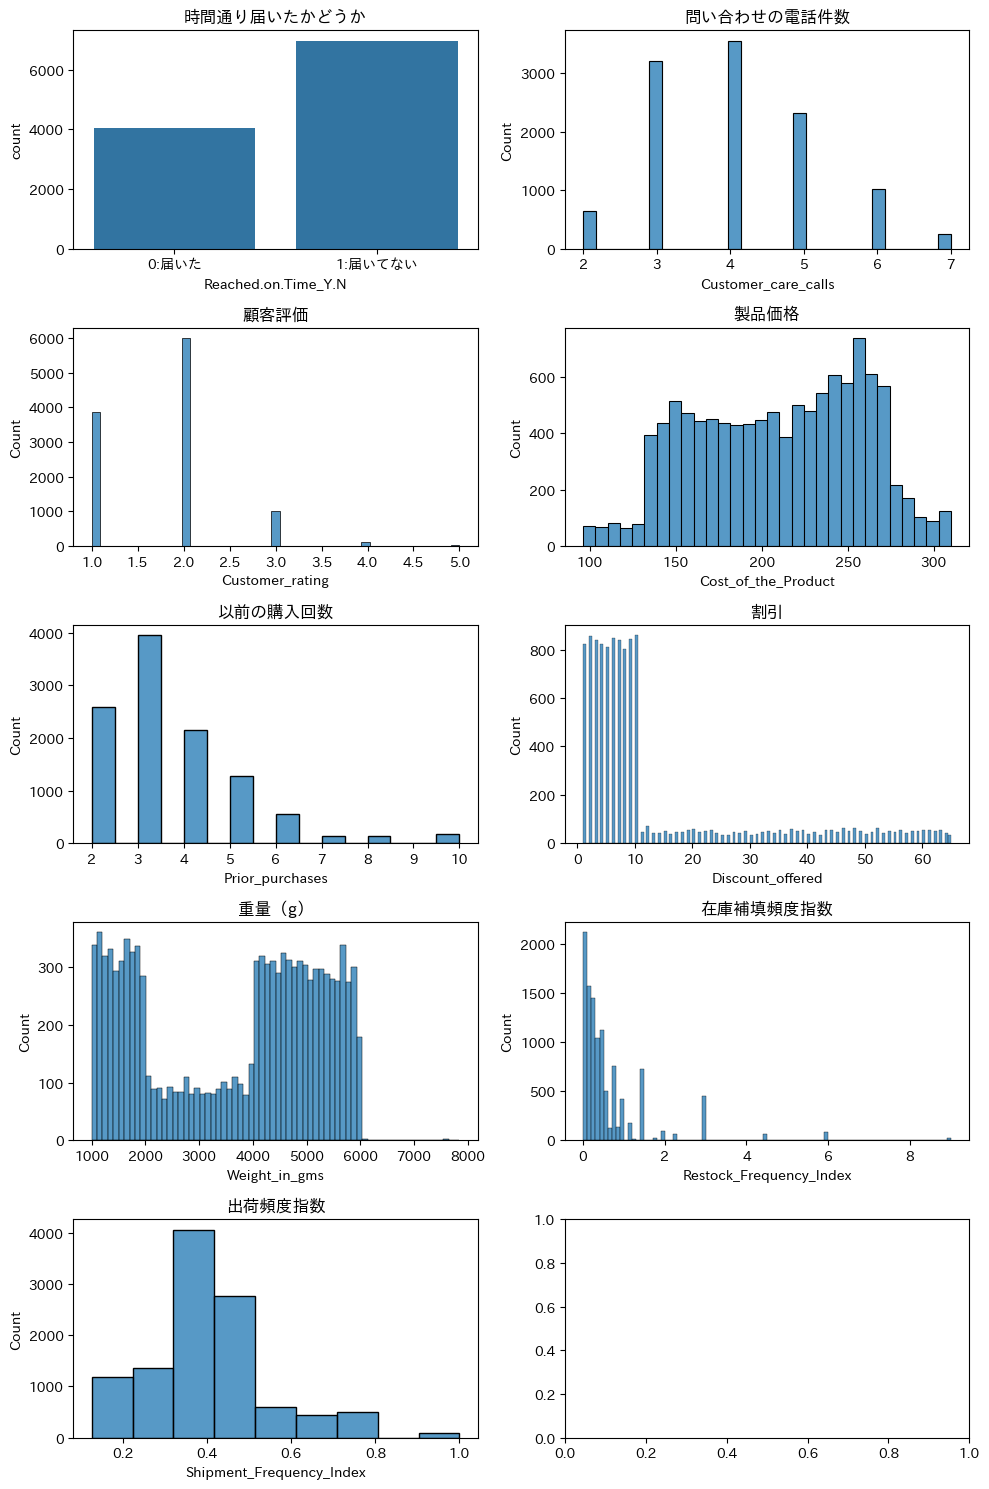

In [ ]:
# Plot configurations
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

# 時間通り届いたかどうか（0:届いた）
sns.countplot(data=df, x="Reached.on.Time_Y.N", ax=axes[0, 0])
axes[0, 0].set_title('時間通り届いたかどうか')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['0:届いた', '1:届いてない'])

# 問い合わせの電話件数
sns.histplot(df, x="Customer_care_calls", kde=False, ax=axes[0, 1])
axes[0, 1].set_title('問い合わせの電話件数')

# 顧客評価
sns.histplot(df, x="Customer_rating", kde=False, ax=axes[1, 0])
axes[1, 0].set_title('顧客評価')

# 製品価格
sns.histplot(df, x="Cost_of_the_Product", kde=False, ax=axes[1, 1])
axes[1, 1].set_title('製品価格')

# 以前の購入回数
sns.histplot(df, x="Prior_purchases", binwidth=0.5, kde=False, ax=axes[2, 0])
axes[2, 0].set_title('以前の購入回数')

# 割引
sns.histplot(df, x="Discount_offered", binwidth=0.5, kde=False, ax=axes[2, 1])
axes[2, 1].set_title('割引')

# 重さ
sns.histplot(df, x="Weight_in_gms", binwidth=100, kde=False, ax=axes[3, 0])
axes[3, 0].set_title('重量（g）')

# 在庫補填頻度
sns.histplot(df, x="Restock_Frequency_Index", binwidth=0.1, kde=False, ax=axes[3, 1])
axes[3, 1].set_title('在庫補填頻度指数')

# 出荷頻度
sns.histplot(df, x="Shipment_Frequency_Index", binwidth=0.1, kde=False, ax=axes[4, 0])
axes[4, 0].set_title('出荷頻度指数')

# Adjust layout
plt.tight_layout()
plt.show()

数値系カラムの可視化により、この企業の配送遅延は約6割を超えていることが分かります。また製品価格は、100～130ドルの範囲の製品が比較的少なく、割引率は0～10％に集中し、重量は2000～4000gの範囲が比較的少ないことが分かります。

単一カラム（カテゴリ系）のヒストグラムを確認します。

In [ ]:
obj_cols = df.select_dtypes(include="object").columns

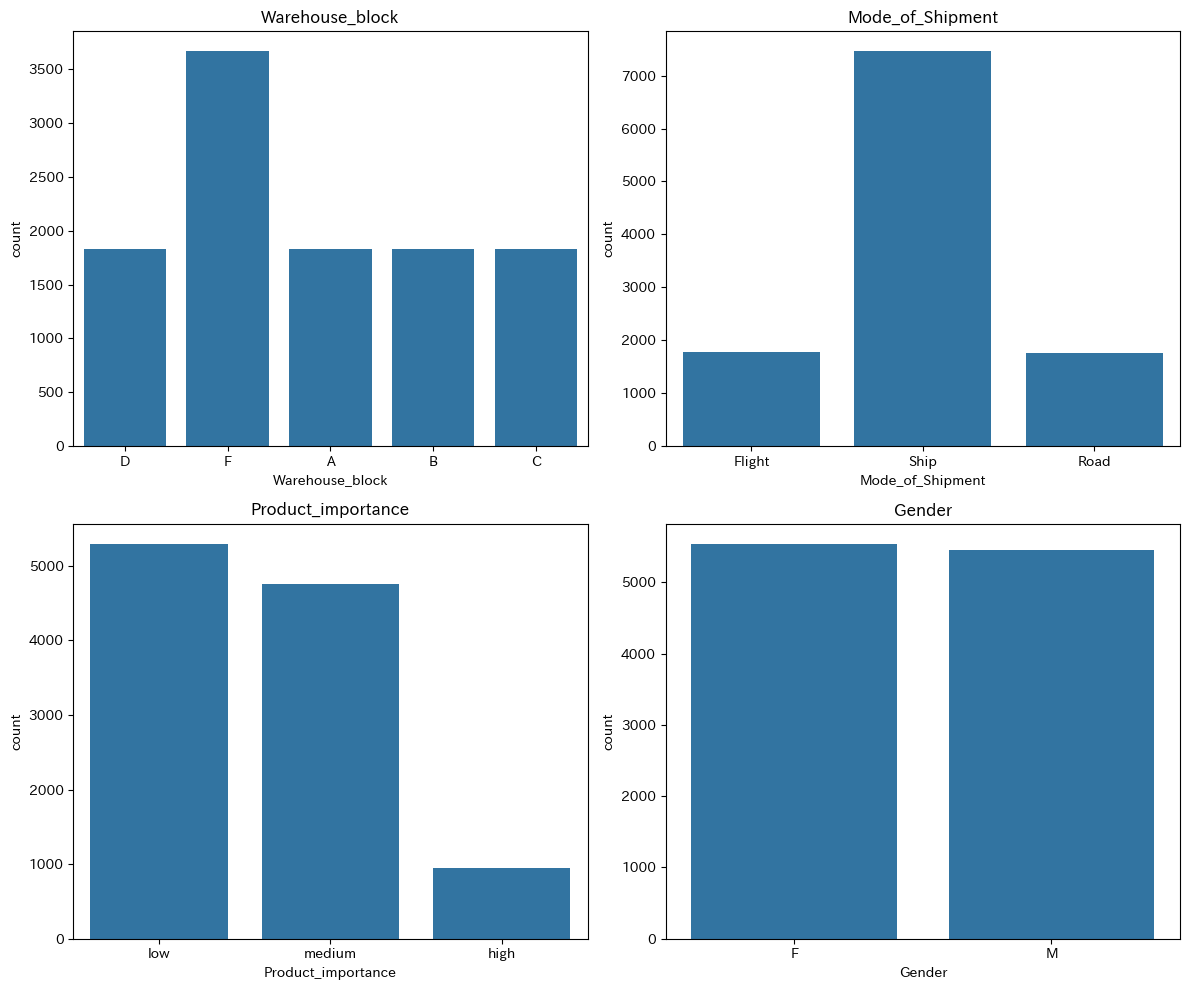

In [ ]:
# 描画設定
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# オブジェクトカラムのグラフ
for i, col in enumerate(obj_cols):
    row = i // 2
    col_num = i % 2
    sns.countplot(data=df, x=col, ax=axes[row, col_num])
    axes[row, col_num].set_title(col)

plt.tight_layout()
plt.show()

倉庫はA～Dまではほぼ等しく、Fが約2倍になっていること、輸送手段はShip(船)が多いこと、製品の重要度はlowとmediumが多く、highの割合は少ないことなどがわかります。

**ここまでのまとめ**
- データ数: 10999
- カラム数: 14
- 欠損値: 無し
- カテゴリカル変数: 4個
- 数値変数: 10個
- オンタイムに届いていない割合が約6割と高い、など


カラムを分析する上で、「売上」のような会社がKPI(重要業績評価指標)とするような目的変数がないかを考えます。
目的変数の候補をここまでの情報から考えてみると、Reached.on.Time_Y.N（時間通りに届いたか否か）が挙げられます。これは配達遅延に関する変数で、配達遅延するか否かを予測することで、製品配送の最適化や顧客満足度の改善・向上に役立つ可能性があります。

また、他に目的変数として考えられるものは、Customer_rating（顧客評価）やCustomer_care_calls（問い合わせの電話件数）なども考えられます。これらは顧客満足度やサービス要望に関する情報であり、ビジネス戦略やサービス提供の最適化に役立つかもしれません。

相関係数を確認します。

<Axes: >

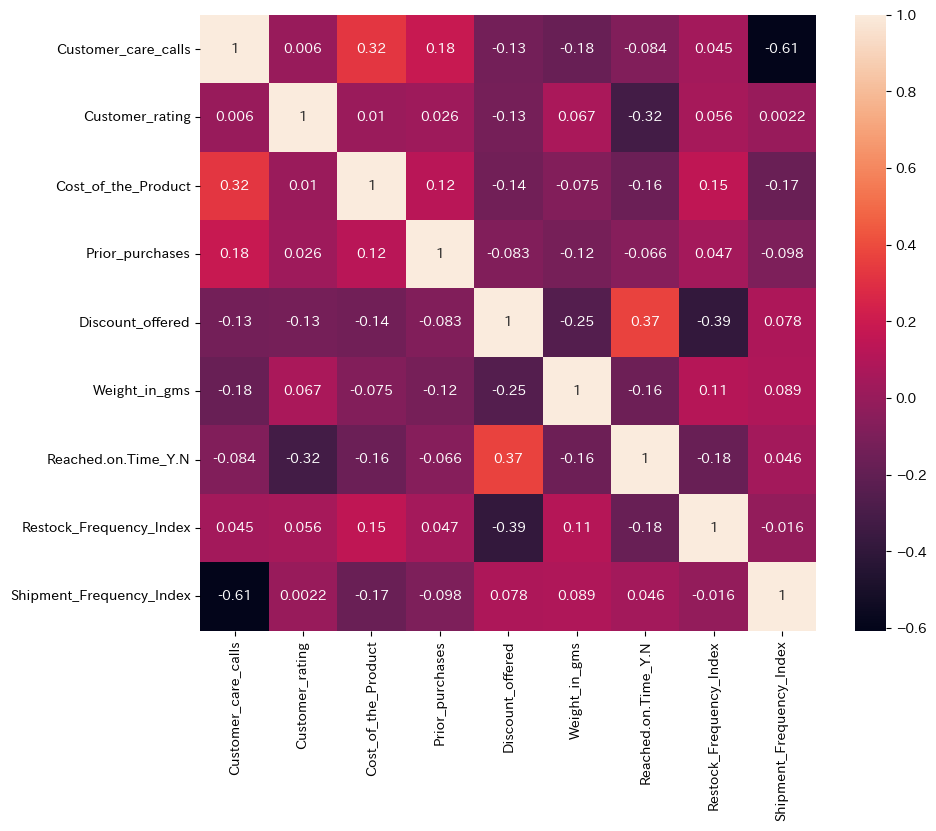

In [ ]:
# 数値データのみで相関行列を計算
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))  # 幅と高さを調整

# 相関行列のヒートマップを表示
sns.heatmap(corr, square=True, annot=True)

ここでは目的変数候補の、Reached.on.Time_Y.Nについての相関係数を確認します。

In [ ]:
corr['Reached.on.Time_Y.N'].sort_values(ascending=False).head(30)

Reached.on.Time_Y.N         1.000000
Discount_offered            0.368086
Shipment_Frequency_Index    0.045919
Prior_purchases            -0.066048
Customer_care_calls        -0.083656
Weight_in_gms              -0.160006
Cost_of_the_Product        -0.164218
Restock_Frequency_Index    -0.178120
Customer_rating            -0.319706
Name: Reached.on.Time_Y.N, dtype: float64

Reached.on.Time_Y.Nと比較的相関係数が高い変数は、「Discount_offered」（正の相関）「Customer_rating」（負の相関）であることが分かります。


目的変数候補のReached.on.Time_Y.Nの割合を、各変数ごとに確認し、傾向を掴んでいきます。

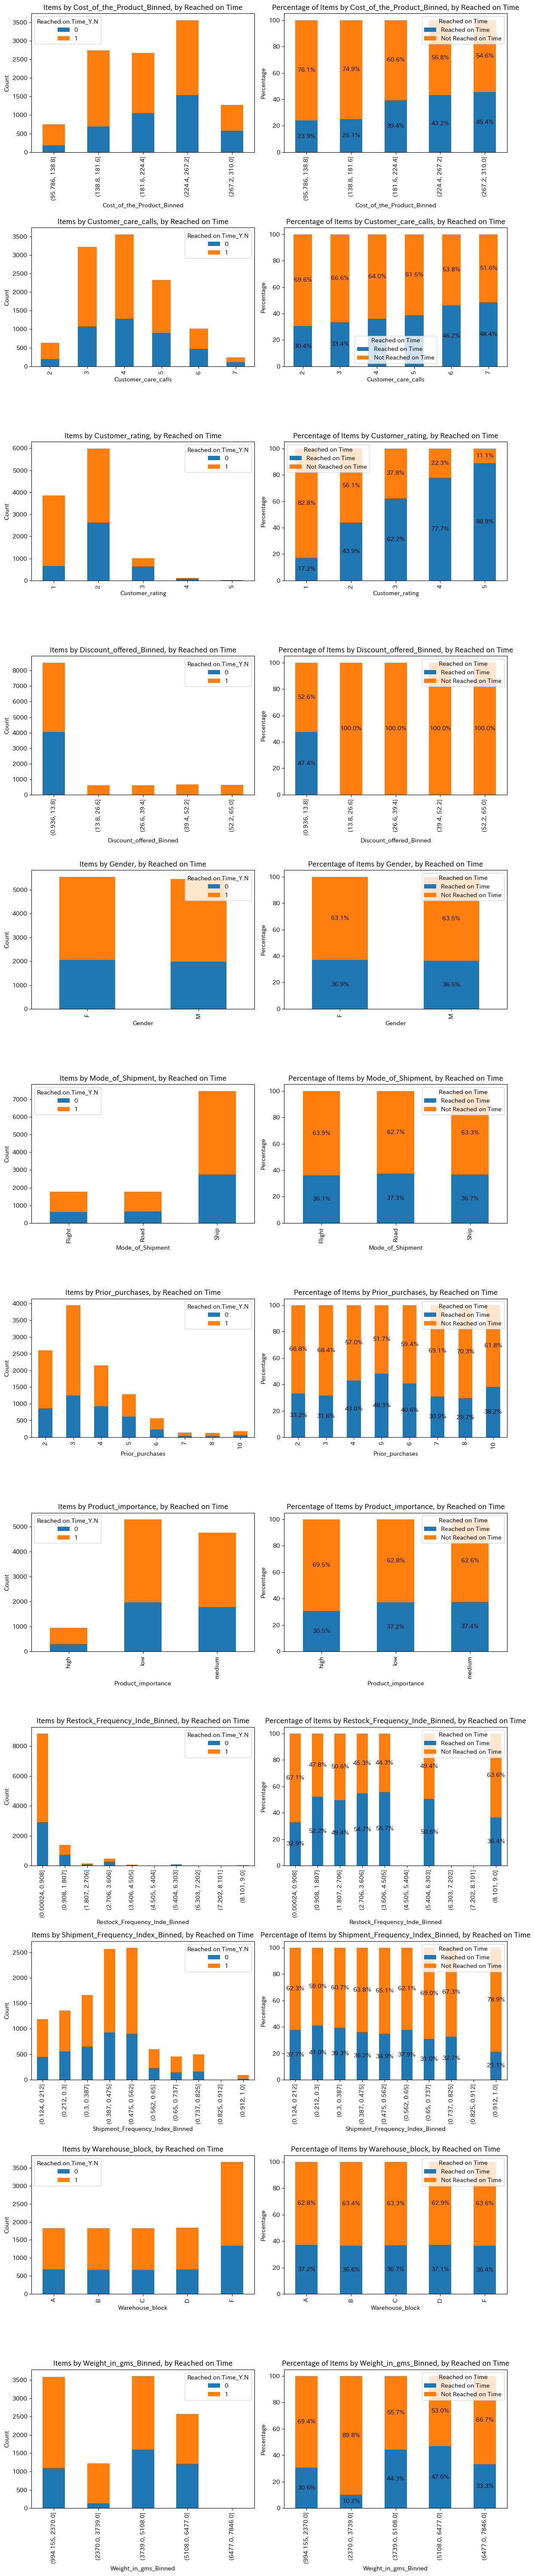

In [ ]:
# コストと重さと割引をビン分け
df['Cost_of_the_Product_Binned'] = pd.cut(df['Cost_of_the_Product'], bins=5)
df['Weight_in_gms_Binned'] = pd.cut(df['Weight_in_gms'], bins=5)
df['Discount_offered_Binned'] = pd.cut(df['Discount_offered'], bins=5)
df['Restock_Frequency_Inde_Binned'] = pd.cut(df['Restock_Frequency_Index'], bins=10)
df['Shipment_Frequency_Index_Binned'] = pd.cut(df['Shipment_Frequency_Index'], bins=10)

columns_to_plot = df.columns.difference(['ID', 'Reached.on.Time_Y.N', 'Cost_of_the_Product', 'Weight_in_gms', 'Discount_offered','Restock_Frequency_Index', 'Shipment_Frequency_Index'])

# 描画設定
fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(12, 5 * len(columns_to_plot)))

# 積み重ねグラフと割合グラフを並べて表示
for i, col in enumerate(columns_to_plot):
    # 重ねグラフ
    grouped = df.groupby([col, 'Reached.on.Time_Y.N']).size().unstack()
    grouped.plot(kind='bar', stacked=True, ax=axes[i, 0])
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].set_title(f'Items by {col}, by Reached on Time')

    # 割合グラフ
    grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100
    ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[i, 1])
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Percentage')
    axes[i, 1].set_title(f'Percentage of Items by {col}, by Reached on Time')
    axes[i, 1].legend(title='Reached on Time', labels=['Reached on Time', 'Not Reached on Time'])

    # 割合の表示
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            ax.text(x + width / 2,
                    y + height / 2,
                    f'{height:.1f}%',
                    horizontalalignment='center',
                    verticalalignment='center')

plt.tight_layout()
plt.show()

以上より、

*   コストが高いと遅延率が低い傾向があること
*   問い合わせ回数が多いと遅延率が低い傾向があること
*   顧客評価が高いと遅延率が低い傾向があること
*   割引率によって100％遅延が起こっている範囲があること
*   配送方法と遅延率は関係が無さそうであること
*   製品重要度がhighの製品の遅延率がlowやmediumに比べて少し高い傾向があること
*   倉庫と遅延率はあまり関係が無さそうであること
*   遅延率が高い製品重量の範囲がありそうであること

などがわかります。

ここで、時系列としては配達後に顧客が評価する、という関係にある'Reached.on.Time_Y.N'（遅延の有無）と'Customer_rating'（顧客評価）に注目してみます。



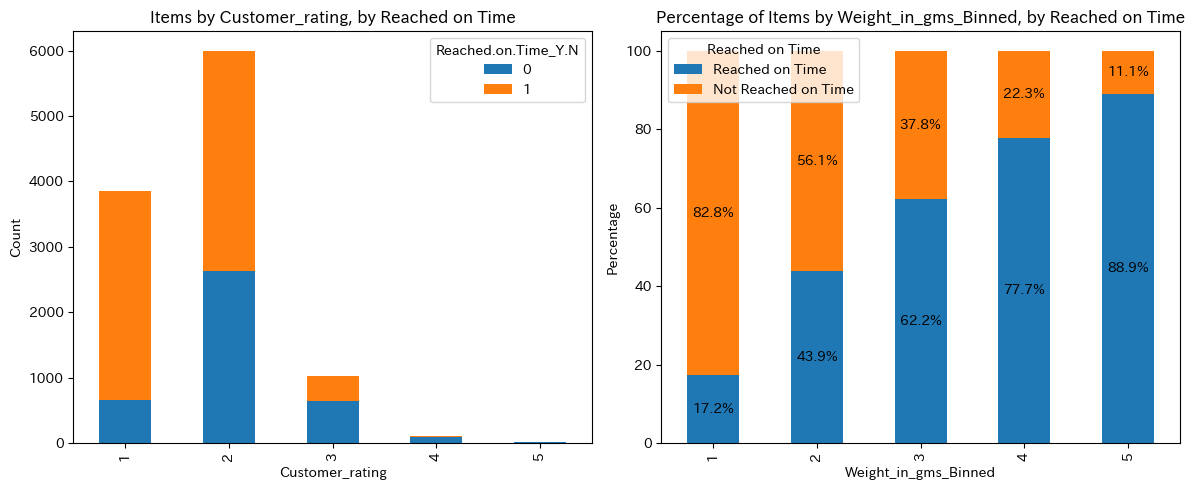

In [ ]:
# 描画設定
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 重ねグラフ
grouped = df.groupby(['Customer_rating', 'Reached.on.Time_Y.N']).size().unstack()
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Customer_rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Items by Customer_rating, by Reached on Time')

# 割合グラフ
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel(col)
axes[1].set_ylabel('Percentage')
axes[1].set_title(f'Percentage of Items by {col}, by Reached on Time')
axes[1].legend(title='Reached on Time', labels=['Reached on Time', 'Not Reached on Time'])

# 割合の表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

plt.tight_layout()
plt.show()

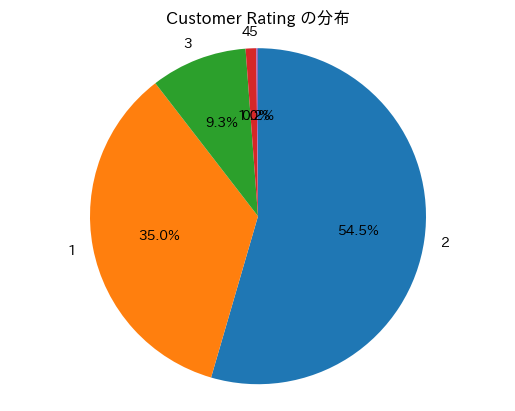

In [ ]:
# Customer_ratingの値のカウントを取得
rating_counts = df['Customer_rating'].value_counts()

# 円グラフを描画
fig, ax = plt.subplots()
ax.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)

# グラフのタイトル
ax.set_title('Customer Rating の分布')

ax.axis('equal')
plt.show()

上記の可視化により、

*   現状、「2」以下の評価（低評価）が約9割となっていること
*   顧客評価と配達遅延の関係を見ると、高評価になるほどオンタイムに届いている割合が高いこと

ということが分かり、遅延改善を行うことで、顧客評価の向上に繋がりそう、ということがわかります。

# 2.課題仮説立案

課題仮説を立てていきます。ここまでのEDAや市場分析から得られた情報を用いて立てていきます。現時点での具体性は低くても問題ありません。仮説立てと検証を繰り返していくことでより良い課題設定を目指します。

課題仮説として、以下のようなものが考えられます。


*   配達遅延割合が高い　（← 数値カラムのEDAから約6割が遅延している）
*   配達予定日の設定が最適でない製品がある　（← 割引率や重量と、遅延有無の関係のEDAから、特定の範囲（割引率10％以上、約2000g～4000gの範囲）の遅延率が高い傾向がわかる）
*   特に配達遅延割合が高い製品群（コストや重さから推定）があることから、需給のバランスが崩れている製品がある　(← 需給のバランスについてはここでは推定のため後ほど深堀っていきます)
*  顧客評価の低評価（「2」以下）の割合が高い　（← EDAより約9割が「2」以下の評価）
*   配達遅延が顧客評価の低下に繋がっている　（← 顧客評価が高いと遅延率が低い傾向があるというEDAからの推定）

遅延改善が顧客評価の向上に繋がっていくことも視野に入れ、

課題仮説を、

「需給バランスの崩れから、配送遅延が高い割合で起こっている製品がある」

として進めていきます。

# 3.課題仮説検証

ここで課題仮説で設定した、「需給バランスの崩れ」、「配送遅延」について、実社会での事実を確認し、この会社が特に配送遅延率（約６割）に課題を抱えていると考えられる根拠をサーベイしていきます。
また、配送遅延を引き起こしている原因や製品などを推定し、具体性を持った提案に繋げていくために、ここまでのEDAで、配送遅延との関連が示唆されている変数に着目して、深堀りをしていきます。


## 3-1.市場分析

今回は以下のように2つほど挙げていますが、実際にはより信頼のおける文献をあたったり、サーベイをする切り口を考え、より多くの資料の中から分析を行っていきます。

*   配送遅延の市場傾向
    *   ヤマト運輸の鉄道物流：長距離区間でが関東から北海道17％、九州15.4％の遅延率
    *   コンテナ船のスケジュール順守率は70~80％台（遅延率20～30％）で推移
    *   一方でこの企業の配送遅延率は約60%と非常に高いと考えられる。
    *   https://www.mlit.go.jp/tetudo/content/001484826.pdf


*   電子部品・デバイス工業の在庫率傾向
    *  2021年の鉱工業指数をみると、出荷の増加に反して在庫が減り、在庫率が悪化していることがわかる。

![市場調査2](https://drive.google.com/uc?id=1lg6dU5hDN67oSJDQFaHG-dSnn-h0Kx73)

以上の２つの事例から、電子部品・デバイス工業業界の在庫率が悪化（出荷が増え、在庫は減っている）している状況下で、この会社では配送遅延が深刻な状況になっていると推察できます。そのような状況下で顧客評価維持、向上を効率的に行うために、優先順位をつけて在庫率、配送遅延を改善していく必要があると考えられます。


## 3-2.EDA

この企業の課題である配送遅延との関連が示唆されている変数に着目し、それぞれ傾向を掴むことで、具体的な原因を推定していきます。

まず、割引率、重量をビン分けし、配送遅延率が高い製品群の分布を確認していきます。

ビン分けにより、割引率11％以上の製品は100％遅延していることが確認できます。

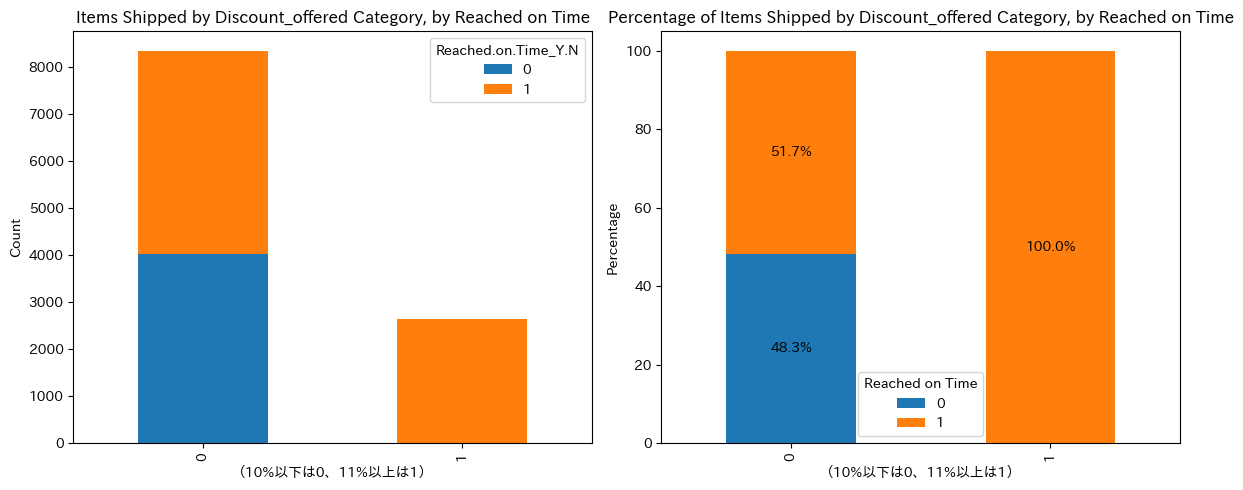

In [ ]:
# 'Discount_offered'を二値化（11%以上は1、10%以下は0）
df['Discount_offered_binary'] = (df['Discount_offered'] >= 11).astype(int)

# Plot configurations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ビンと'Reached.on.Time_Y.N'でグループ化してカウント
grouped = df.groupby(['Discount_offered_binary', 'Reached.on.Time_Y.N']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('（10%以下は0、11%以上は1）')
axes[0].set_ylabel('Count')
axes[0].set_title('Items Shipped by Discount_offered Category, by Reached on Time')

# 各モードの合計で正規化してパーセンテージを計算
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 積み上げバーグラフをプロット
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('（10%以下は0、11%以上は1）')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Items Shipped by Discount_offered Category, by Reached on Time')
axes[1].legend(title='Reached on Time')

# バーの上にパーセンテージを表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 高さが0以上の場合のみラベルを表示
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

# プロット表示
plt.tight_layout()
plt.show()

ビン分けにより、2000g～4000gの製品群は遅延率が高いことがわかります。

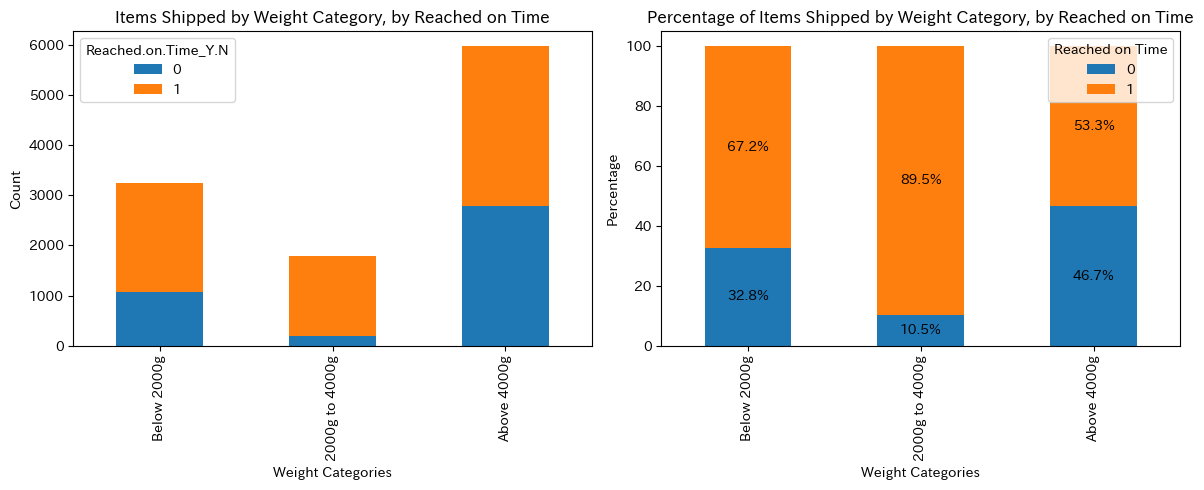

In [ ]:
# 'Weight_in_gms'をカテゴライズ
df['Weight_category'] = pd.cut(df['Weight_in_gms'], bins=[0, 2000, 4000, float('inf')], labels=['Below 2000g', '2000g to 4000g', 'Above 4000g'])

# Plot configurations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ビンと'Reached.on.Time_Y.N'でグループ化してカウント
grouped = df.groupby(['Weight_category', 'Reached.on.Time_Y.N']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Weight Categories')
axes[0].set_ylabel('Count')
axes[0].set_title('Items Shipped by Weight Category, by Reached on Time')

# 各モードの合計で正規化してパーセンテージを計算
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 積み上げバーグラフをプロット
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Weight Categories')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Items Shipped by Weight Category, by Reached on Time')
axes[1].legend(title='Reached on Time')

# バーの上にパーセンテージを表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 高さが0以上の場合のみラベルを表示
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

# プロット表示
plt.tight_layout()
plt.show()

2000g～4000gの製品群の遅延と輸送手段の関係を確認し、あまり関係がないことがわかります。

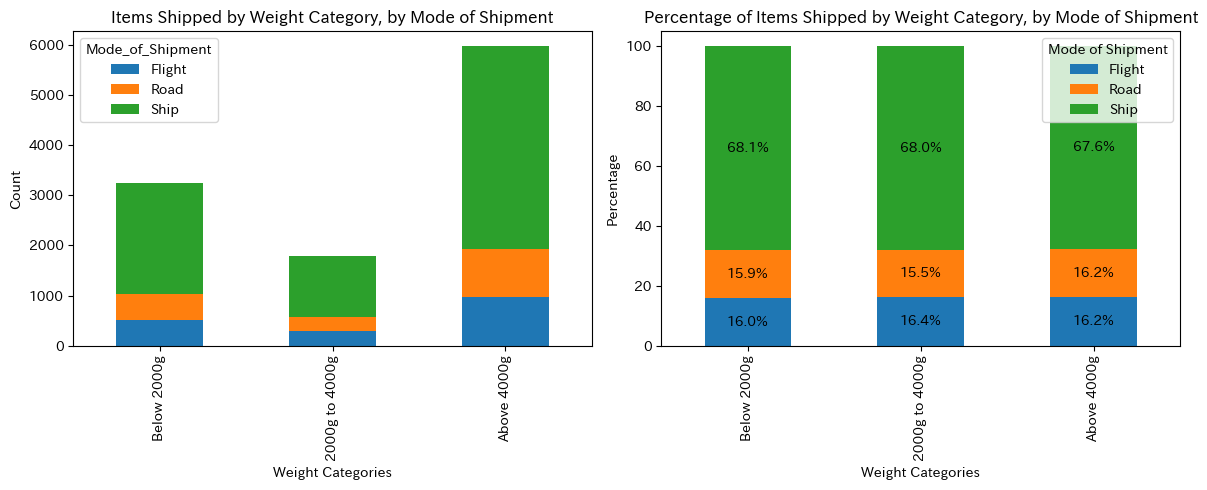

In [ ]:
# Plot configurations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ビンと'Mode_of_Shipment'でグループ化してカウント
grouped = df.groupby(['Weight_category', 'Mode_of_Shipment']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Weight Categories')
axes[0].set_ylabel('Count')
axes[0].set_title('Items Shipped by Weight Category, by Mode of Shipment')

# 各モードの合計で正規化してパーセンテージを計算
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 積み上げバーグラフをプロット
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Weight Categories')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Items Shipped by Weight Category, by Mode of Shipment')
axes[1].legend(title='Mode of Shipment')

# バーの上にパーセンテージを表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 高さが0以上の場合のみラベルを表示
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

# プロット表示
plt.tight_layout()
plt.show()

2000g～4000gの製品群の遅延と倉庫の関係を確認し、あまり関係がないことがわかります。

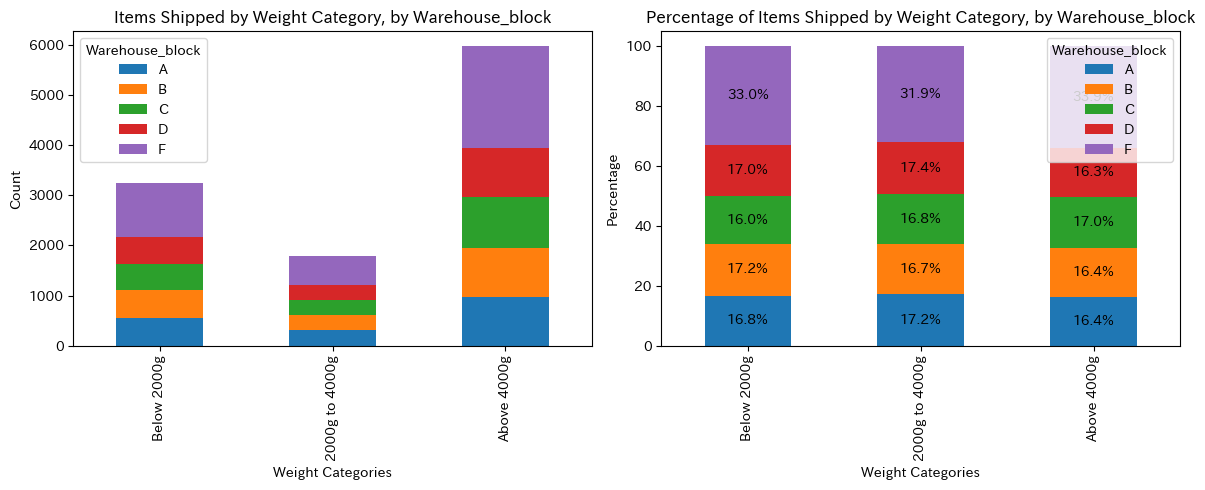

In [ ]:
# Plot configurations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ビンと'Warehouse_block'でグループ化してカウント
grouped = df.groupby(['Weight_category', 'Warehouse_block']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Weight Categories')
axes[0].set_ylabel('Count')
axes[0].set_title('Items Shipped by Weight Category, by Warehouse_block')

# 各モードの合計で正規化してパーセンテージを計算
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 積み上げバーグラフをプロット
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Weight Categories')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Items Shipped by Weight Category, by Warehouse_block')
axes[1].legend(title='Warehouse_block')

# バーの上にパーセンテージを表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 高さが0以上の場合のみラベルを表示
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

# プロット表示
plt.tight_layout()
plt.show()

2000g～4000gの製品群には、ディスカウント率が11％以上の製品が多いことがわかります。


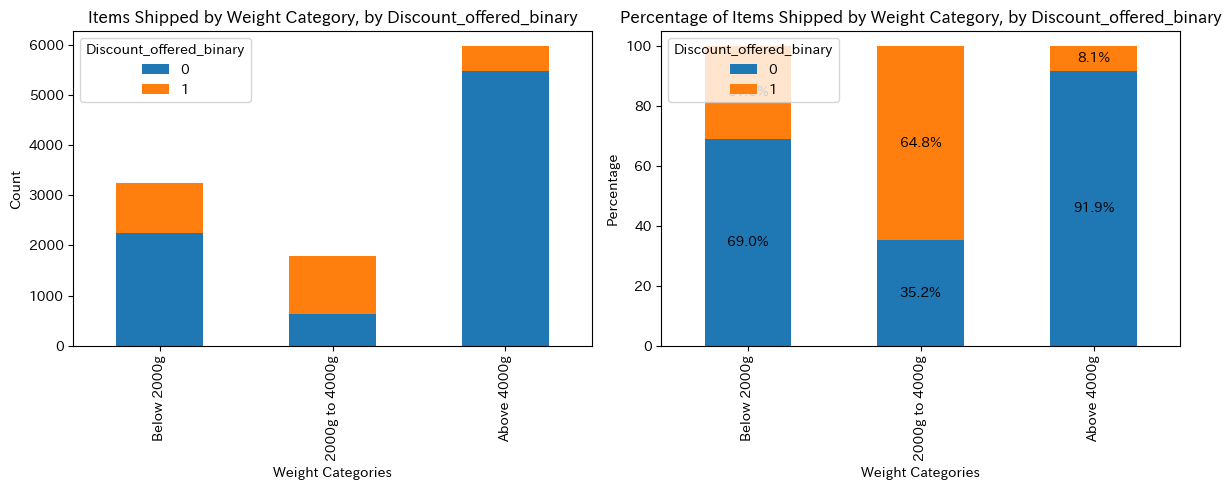

In [ ]:
# Plot configurations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ビンと'Discount_offered_binary'でグループ化してカウント
grouped = df.groupby(['Weight_category', 'Discount_offered_binary']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Weight Categories')
axes[0].set_ylabel('Count')
axes[0].set_title('Items Shipped by Weight Category, by Discount_offered_binary')

# 各モードの合計で正規化してパーセンテージを計算
grouped_pct = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 積み上げバーグラフをプロット
ax = grouped_pct.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Weight Categories')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Percentage of Items Shipped by Weight Category, by Discount_offered_binary')
axes[1].legend(title='Discount_offered_binary')

# バーの上にパーセンテージを表示
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 高さが0以上の場合のみラベルを表示
        ax.text(x + width / 2,
                y + height / 2,
                f'{height:.1f}%',
                horizontalalignment='center',
                verticalalignment='center')

# プロット表示
plt.tight_layout()
plt.show()

## 3-3.特徴量を作成

ここで、配達遅延の原因を推定していくにあたり、課題仮説で設定した「需給のバランスの崩れ」と配達遅延の関係を確認するため、「需給バランス」を表すカラムを既存カラムを利用して作成します。

**需給指標 = 在庫補填頻度指数 / 出荷頻度指数**

→値が大きいほど需要に対して在庫が確保できている指標となります。

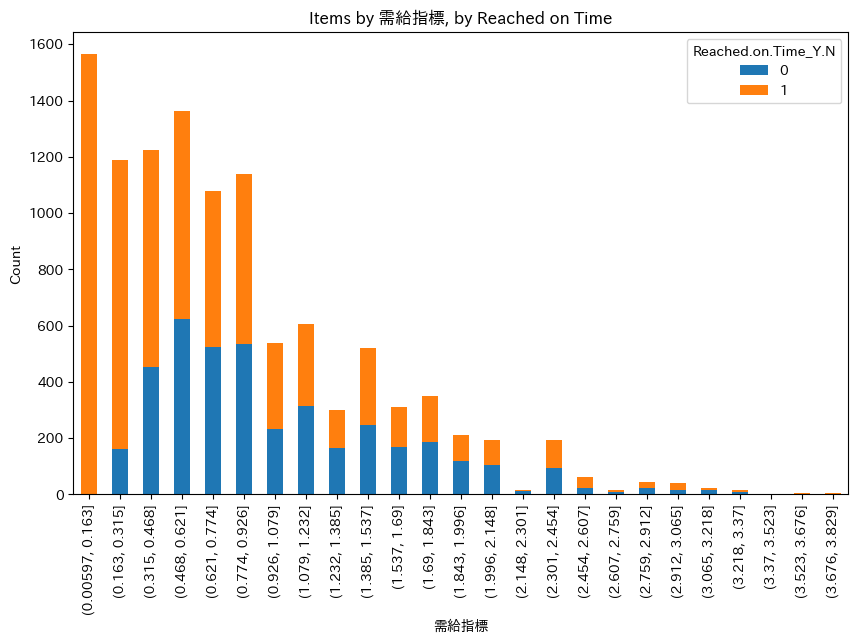

In [ ]:
# 需給指標を計算して新しいカラムを作成
df['需給指標'] = df['Restock_Frequency_Index'] / df['Shipment_Frequency_Index']

# 正規化（平方根変換）
df['需給指標'] = np.log1p(df['需給指標'])

# 正規化された需給指標を25のビンに分割
df['需給指標_binned'] = pd.cut(df['需給指標'], bins=25)

# グループ化して重ねグラフを作成
fig, ax = plt.subplots(figsize=(10, 6))
grouped = df.groupby(['需給指標_binned', 'Reached.on.Time_Y.N']).size().unstack()
grouped.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('需給指標')
ax.set_ylabel('Count')
ax.set_title('Items by 需給指標, by Reached on Time')

plt.show()

作成した特徴量「需給指標」と配達遅延の関係を確認すると、需給指標が0.3以下の遅延割合が高いことが分かります。

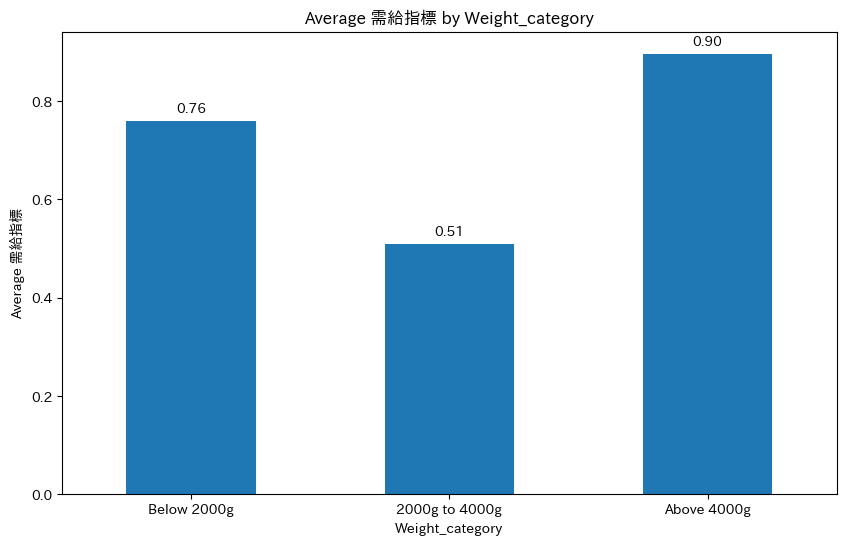

In [ ]:
# ビンごとの需給指標の平均を計算
bin_means = df.groupby('Weight_category')['需給指標'].mean()

# グラフを作成
plt.figure(figsize=(10, 6))
ax = bin_means.plot(kind='bar')
plt.title('Average 需給指標 by Weight_category')
plt.xlabel('Weight_category')
plt.ylabel('Average 需給指標')
plt.xticks(rotation=0)

# バーの上に数値を表示
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

重さでビン分けした中での需給指標の平均値を確認すると、2000g～4000gの需給指標が小さく（平均0.51）、4000g以上の需給指標が大きい（平均0.90）ことが分かります。先ほどのEDAにより、2000g～4000gの配達遅延率が高く、4000g以上の配達遅延率が低いことから、配達遅延と需給指標が関係していそうなことがわかります。

そこで、需給指標0.5以上か以下で配達遅延の分布を確認してみます。

需給指標0.5以下では、配達遅延が多く起こっていることがわかります。

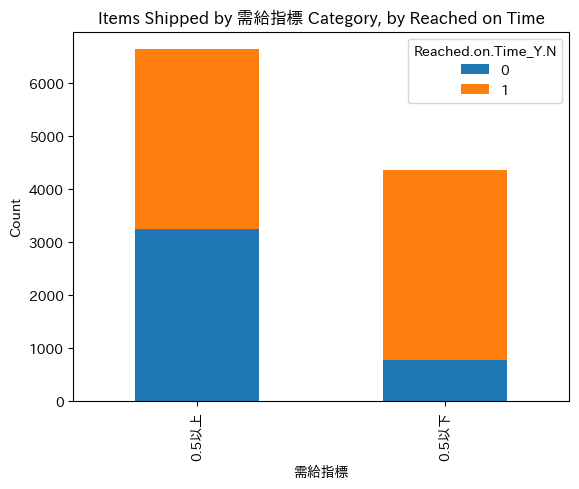

In [ ]:
# 0.5以上か0.5以下で分ける新しいカラムを作成
df['需給指標_bin'] = df['需給指標'].apply(lambda x: '0.5以上' if x >= 0.5 else '0.5以下')

# ビンと'Reached.on.Time_Y.N'でグループ化してカウント
grouped = df.groupby(['需給指標_bin', 'Reached.on.Time_Y.N']).size().unstack()

# 積み上げ棒グラフを描画
grouped.plot(kind='bar', stacked=True)

# 軸ラベルとタイトルの設定
plt.xlabel('需給指標')
plt.ylabel('Count')
plt.title('Items Shipped by 需給指標 Category, by Reached on Time')

# グラフの表示
plt.show()

新しく作成した特徴量も含め、相関係数を確認します。

<Axes: >

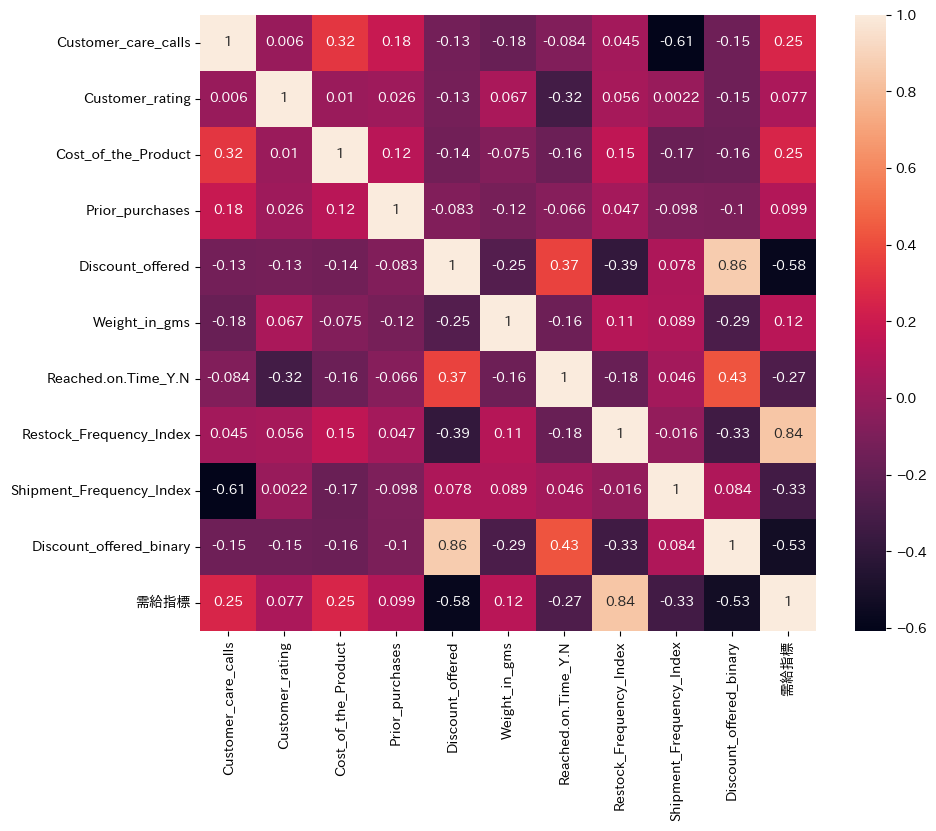

In [ ]:
# 数値データのみで相関行列を計算
corr = df.corr(numeric_only=True)

# 相関行列のヒートマップを表示
plt.figure(figsize=(10, 8))  # 幅と高さを調整
sns.heatmap(corr, square=True, annot=True)

## 3-4.「Reached.on.Time_Y.N」を目的変数としてモデル作成、寄与度などを確認

Reached.on.Time_Y.Nを目的変数とした予測モデルを作成し、説明変数の重要度分析を行い、これまでのEDAや市場分析で得られた情報と合わせ、打ち手仮説立案に繋げていきます。

In [ ]:
# カラム指定
columns_select = [
    'Warehouse_block',
    'Mode_of_Shipment',
    'Customer_care_calls',
#    'Customer_rating',  #届いた後のことなので除く
    'Cost_of_the_Product',
    'Prior_purchases',
    'Product_importance',
    'Gender',
#    'Discount_offered',  #多重共線性の除去
    'Weight_in_gms',
    'Reached.on.Time_Y.N',
    '需給指標'
]

# カラムを選定
df2 = df.loc[:, columns_select]

# データフレームを表示
df2.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Weight_in_gms,Reached.on.Time_Y.N,需給指標
0,D,Flight,4,177,3,low,F,5335,1,0.157392
1,F,Flight,4,216,2,low,M,2941,1,0.119665
2,A,Flight,2,183,4,low,M,3374,1,0.171850
3,B,Flight,3,176,4,medium,M,1149,1,0.788457
4,C,Flight,2,184,3,medium,F,2484,1,0.178692


まず、カテゴリー変数をラベルエンコーディングしておきます。

In [ ]:
# カテゴリカル変数のエンコーディング
le = LabelEncoder()
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for feature in categorical_features:
    df2[feature] = le.fit_transform(df[feature])

In [ ]:
df2

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Weight_in_gms,Reached.on.Time_Y.N,需給指標
0,3,0,4,177,3,1,0,5335,1,0.157392
1,4,0,4,216,2,1,1,2941,1,0.119665
2,0,0,2,183,4,1,1,3374,1,0.171850
3,1,0,3,176,4,2,1,1149,1,0.788457
4,2,0,2,184,3,2,0,2484,1,0.178692
...,...,...,...,...,...,...,...,...,...,...
10994,0,2,4,252,5,2,0,1014,1,2.772589
10995,1,2,4,232,5,2,0,1247,0,0.810930
10996,2,2,5,242,5,1,0,1781,0,1.178655
10997,4,2,5,223,6,2,1,1210,0,1.704748


In [ ]:
# データを特徴量とターゲットに分割
X = df2.drop(['Reached.on.Time_Y.N'], axis=1)
y = df2['Reached.on.Time_Y.N']

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのパラメータ設定
# 以下パラメータはoptunaにより探索
params = {
    'objective': 'binary',
    'metric': 'auc',
    'feature_pre_filter': False,
    'lambda_l1': 0.00013968674188118347,
    'lambda_l2': 6.237708525896343,
    'num_leaves': 2,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8298255165822404,
    'bagging_freq': 7,
    'min_child_samples': 20,
    'verbose': -1,
    'seed': 42
    }

# データセットの作成
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# モデルの訓練
model = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval)

In [ ]:
# テストデータに対する予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

作成したモデルの評価指標として、２値分類であることと、真陽性率（True Positive Rate）と偽陽性率（False Positive Rate）のバランスを取って評価し、モデルの精度を汎用的に計測することができるAUCを用いることにします。

In [ ]:
# 評価指標の計算
roc_auc = roc_auc_score(y_test, y_pred)

# 評価指標の表示
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.7694529284585082


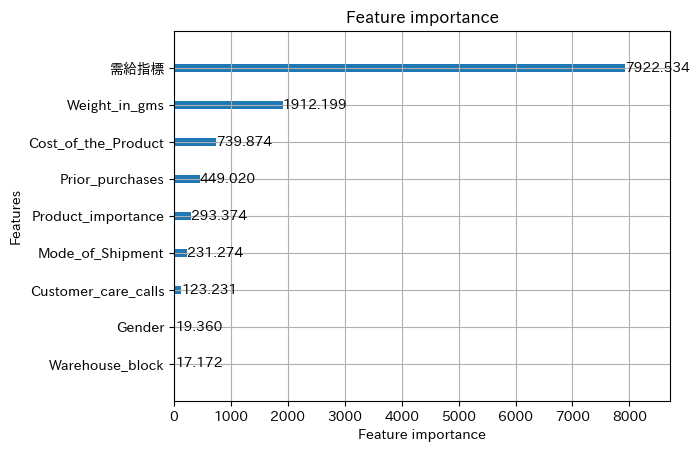

In [ ]:
# 特徴量の重要度をプロット
lgb.plot_importance(model, importance_type='gain')
plt.show()

需給指標と配達遅延の有無でウィルコクソンの順位和検定を有意水準を5%として検定し、2群の中央値に有意差があるか検討してみます。

In [ ]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(df[df["Reached.on.Time_Y.N"]==1]["需給指標"]
                , df[df["Reached.on.Time_Y.N"]==0]["需給指標"]
                ,alternative='two-sided')
pvalue < 0.05

True

pvalue < 0.05がTrueとなったため、配達遅延の有無に関して、需給指標に有意差があることが分かりました。

ここで、市場分析より業界全体として在庫率が悪化していることも鑑み、優先順位をつけてより効率的に配達遅延を改善できるよう、特に配達遅延が高い製品群を特定していきます。

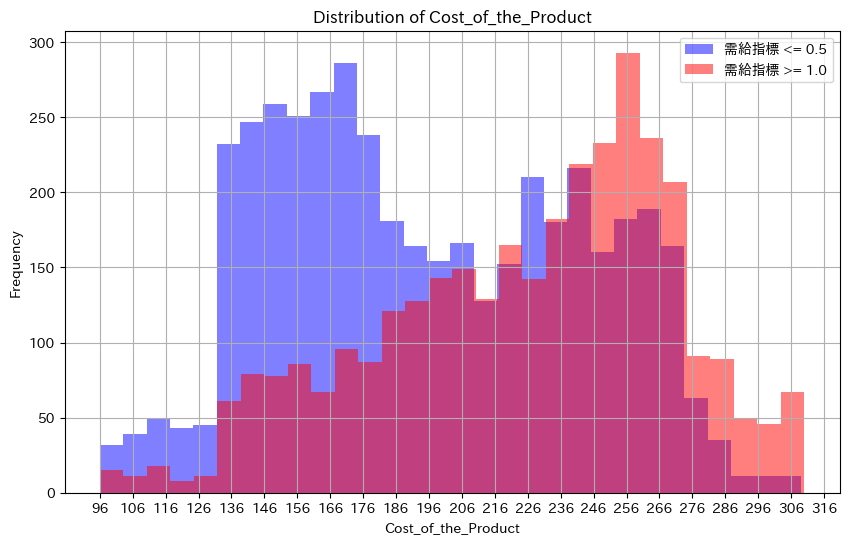

In [ ]:
import matplotlib.pyplot as plt

# '需給指標'が0.25以下のデータをフィルタリング
filtered_df_below_0_5 = df2[df2['需給指標'] <= 0.5]

# '需給指標'が0.7以上のデータをフィルタリング
filtered_df_above_1 = df2[df2['需給指標'] >= 1.0]

# 'Cost_of_the_Product'のヒストグラムを作成
plt.figure(figsize=(10, 6))

# '需給指標'が0.5以下のヒストグラム
plt.hist(filtered_df_below_0_5['Cost_of_the_Product'], bins=30, alpha=0.5, color='blue', label='需給指標 <= 0.5')

# '需給指標'が1.0以上のヒストグラム
plt.hist(filtered_df_above_1['Cost_of_the_Product'], bins=30, alpha=0.5, color='red', label='需給指標 >= 1.0')

# x軸の目盛りを10刻みに設定
plt.xticks(range(int(df2['Cost_of_the_Product'].min()), int(df2['Cost_of_the_Product'].max()) + 10, 10))

plt.title('Distribution of Cost_of_the_Product')
plt.xlabel('Cost_of_the_Product')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

低～中価格帯（90～180ドル）の製品が、需給指標<0.5の割合が、中価格帯（180ドル～）以上の製品に比べて多いことがわかり、そこを改善する施策が効果的でありそうだということがわかります。

# 4.打ち手仮説立案

ここまでのEDAにより、配送遅延を効率的に改善する打ち手案を考えます。

*   製品の需給を改善する
  *   需給指標が小さく（0.5以下）、配送遅延が発生していると考えられる製品群の需給を改善する
  *   需給指標が小さい製品の割合が多い製品群（90～180ドルの低～中価格帯の製品）に絞って需給を改善する

*   割引率を調整する
  *   割引率が11％以上の製品が100％遅延しているため、割引率を11％以下にする

割引率の調整により、需要が下がり、出荷量が減ることで配送遅延に繋がる可能性はありますが、それも「製品の需給を改善する」に含まれると考え、製品の需給を改善する2つの打ち手仮説を検証していきます。

# 5.打ち手仮説検証1

配達遅延率が高い需給指標<=0.5の製品群の需給を改善した効果をモデルを用いて予測します。

ここで、需給指標<=0.5となっている製品群の出荷指数と在庫補填指数の組み合わせの分布を確認し、需給指標=1.0にするために、在庫補填と出荷をそれぞれどのように調整するかを仮定します。

需給指標<=0.5以下の分布を確認します。

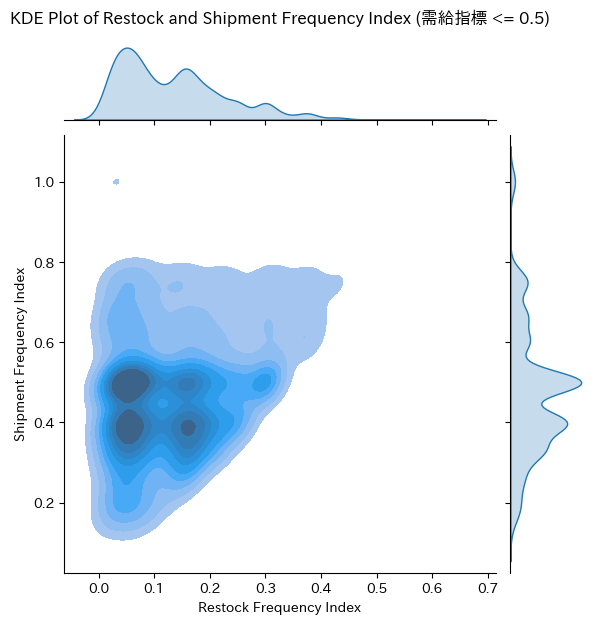

In [ ]:
filtered_df = df[df['需給指標'] <= 0.5]

# Seabornのjointplotを使ってカーネル密度推定を描画
sns.jointplot(
    x='Restock_Frequency_Index', y='Shipment_Frequency_Index',
    data=filtered_df, kind='kde', fill=True
)
plt.xlabel('Restock Frequency Index')
plt.ylabel('Shipment Frequency Index')
plt.title('KDE Plot of Restock and Shipment Frequency Index (需給指標 <= 0.5)', pad=80)
plt.show()

需給指標>=1.0以上の分布を確認します。

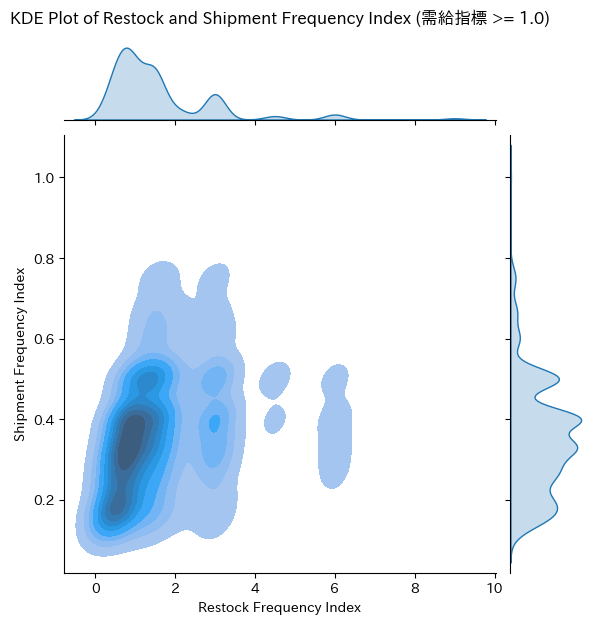

In [ ]:
# 需給指標の値が1.0以上の行をフィルタリング
filtered_df2 = df[df['需給指標'] >= 1.0]

# Seabornのjointplotを使ってカーネル密度推定を描画
sns.jointplot(
    x='Restock_Frequency_Index', y='Shipment_Frequency_Index',
    data=filtered_df2, kind='kde', fill=True
)
plt.xlabel('Restock Frequency Index')
plt.ylabel('Shipment Frequency Index')
plt.title('KDE Plot of Restock and Shipment Frequency Index (需給指標 >= 1.0)', pad=80)
plt.show()

需給指標（'Restock_Frequency_Index'/ 'Shipment_Frequency_Index'）が0.5以下の値をとっている製品と、1.0以上の製品のの需給の分布を比較すると、0.5以下の値をとっている製品は、'Shipment_Frequency_Index'の値が少し大きい（出荷が多い
）方に分布し、'Restock_Frequency_Index'の値がかなり少ない（在庫がかなり少ない）ことが確認できます。

そこで、需給のバランスを、出荷を絞りつつ、在庫補填を増やして調整するために、各製品の現状の'Restock_Frequency_Index'と 'Shipment_Frequency_Index'の中間値に調整し、需給指標=1.0にすることにします。

In [ ]:
# Restock_Frequency_IndexとShipment_Frequency_Indexの調整
adjusted_df = filtered_df.copy()
adjusted_df['Adjusted_Restock_Frequency_Index'] = (filtered_df['Restock_Frequency_Index'] + filtered_df['Shipment_Frequency_Index']) / 2
adjusted_df['Adjusted_Shipment_Frequency_Index'] = adjusted_df['Adjusted_Restock_Frequency_Index']

# 結果を表示
adjusted_df_display = adjusted_df[['需給指標', 'Restock_Frequency_Index', 'Shipment_Frequency_Index', 'Adjusted_Restock_Frequency_Index', 'Adjusted_Shipment_Frequency_Index']]

print(adjusted_df_display)

           需給指標  Restock_Frequency_Index  Shipment_Frequency_Index  \
0      0.157392                 0.034091                  0.200000   
1      0.119665                 0.025424                  0.200000   
2      0.171850                 0.062500                  0.333333   
4      0.178692                 0.065217                  0.333333   
7      0.145182                 0.031250                  0.200000   
...         ...                      ...                       ...   
10950  0.485508                 0.375000                  0.600000   
10954  0.271934                 0.187500                  0.600000   
10981  0.371564                 0.150000                  0.333333   
10985  0.371564                 0.150000                  0.333333   
10998  0.318454                 0.250000                  0.666667   

       Adjusted_Restock_Frequency_Index  Adjusted_Shipment_Frequency_Index  
0                              0.117045                           0.117045  
1    

その調整を行うことで、在庫補填指数と出荷指数を、それぞれどの程度調整する必要があるかを確認します。

In [ ]:
# 増加・減少の割合を計算
restock_increase_percentage = ((adjusted_df['Adjusted_Restock_Frequency_Index'] - filtered_df['Restock_Frequency_Index']) / filtered_df['Restock_Frequency_Index']).mean() * 100
shipment_decrease_percentage = ((filtered_df['Shipment_Frequency_Index'] - adjusted_df['Adjusted_Shipment_Frequency_Index']) / filtered_df['Shipment_Frequency_Index']).mean() * 100

print(f"Restock_Frequency_Indexが平均して{restock_increase_percentage:.2f}%増加")
print(f"Shipment_Frequency_Indexが平均して{shipment_decrease_percentage:.2f}%減少")

Restock_Frequency_Indexが平均して286.60%増加
Shipment_Frequency_Indexが平均して35.34%減少


打ち手仮説1の検証では、在庫補填を平均約2.86倍し、出荷を平均約3.5割絞ることで、需給を改善(需給指標=1)するという設定とします。

改善前（y_test）の遅延の割合を確認します。

In [ ]:
# 2値のカウント
unique, counts = np.unique(y_test, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)

{0: 809, 1: 1391}


改善前（y_test）の中の遅延件数は1391件です。

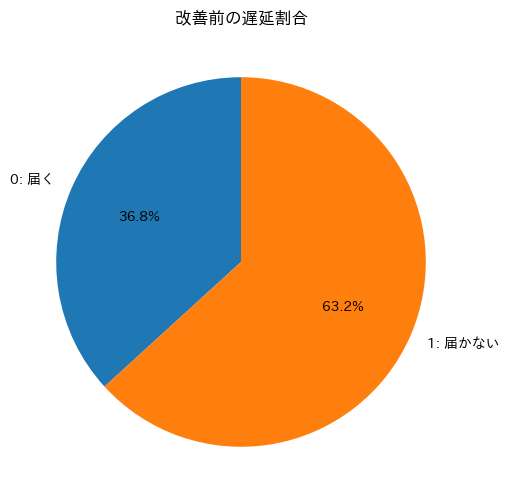

In [ ]:
# 値の頻度を計算
values, counts = np.unique(y_test, return_counts=True)

# ラベルの変換
labels = ['0: 届く' if value == 0 else '1: 届かない' for value in values]

# 円グラフを作成
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# グラフのタイトルを追加
plt.title('改善前の遅延割合')

plt.show()

In [ ]:
df_1 = X_test.copy()

<Axes: >

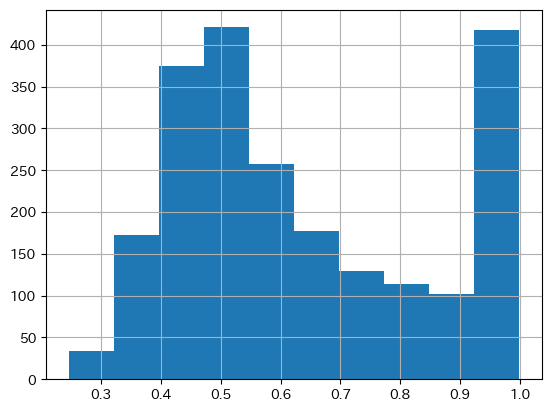

In [ ]:
df_1['pred1']= y_pred
df_1['pred1'].hist()

In [ ]:
#最適な閾値の検索
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.6823509949064244


In [ ]:
#閾値で2値に振り分け
y_pred_binary = (y_pred >=  0.6823509949064244).astype(int)

In [ ]:
# 2値のカウント
unique, counts = np.unique(y_pred_binary, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)

{0: 1409, 1: 791}


（施策前）作成したモデルが予測した遅延件数：**791件**

ここで、全製品数を、「製品価格」と「需給指標」の組み合わせ数から、8477製品であると推定します。

In [ ]:
# 組み合わせの数（製品数）
total_unique_combinations = df[['Cost_of_the_Product', '需給指標']].drop_duplicates().shape[0]
total_unique_combinations

8477

施策後の効果をモデルを用いて予測するため、「需給指標」が0.5以下の製品の需給指標を1.0に改善します。

In [ ]:
# 条件でフィルタリング
filtered_df = X_test[(X_test['需給指標'] <= 0.5)]

# 選択した行の 需給指標 の値を 1 に書き換える
X_test2 = X_test.copy()
X_test2.loc[filtered_df.index, '需給指標'] = 1.0

# 結果を確認
print(X_test2.loc[filtered_df.index])

       Warehouse_block  Mode_of_Shipment  Customer_care_calls  \
5594                 0                 1                    3   
3111                 1                 2                    5   
6606                 3                 2                    4   
8749                 4                 1                    4   
1851                 1                 2                    3   
...                ...               ...                  ...   
1558                 2                 2                    2   
7925                 4                 1                    4   
2058                 3                 0                    5   
3909                 1                 2                    2   
10317                1                 2                    2   

       Cost_of_the_Product  Prior_purchases  Product_importance  Gender  \
5594                   220                3                   1       0   
3111                   229                2                   2      

{0: 1783, 1: 417}


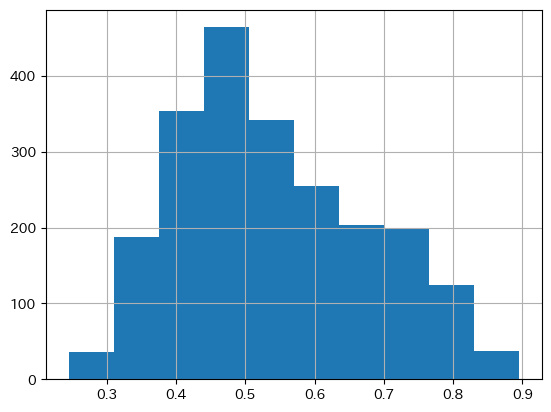

In [ ]:
y_pred2 = model.predict(X_test2)
y_pred2_binary = (y_pred2 >=  0.6823509949064244).astype(int)
df_1['pred2']= y_pred2
df_1['pred2'].hist()
# 2値のカウント
unique, counts = np.unique(y_pred2_binary, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)

施策後、作成したモデルが予測した遅延件数が374件減少(1409件中)→**約26.8％**の遅延が改善することがわかります。（791-417=374, 374/1391=26.8%）

In [ ]:
# 指定された条件でフィルタリング
filtered_df2 = df[(df['需給指標'] <= 0.5)]

# ユニークな組み合わせの数（製品数）を確認
unique_combinations_filtered = filtered_df2[['Cost_of_the_Product', '需給指標']].drop_duplicates().shape[0]

# 割合を計算
percentage = (unique_combinations_filtered / total_unique_combinations) * 100

print(f"改善する製品の数: {unique_combinations_filtered}")
print(f"改善する製品の割合: {percentage:.2f}%")

改善する製品の数: 3916
改善する製品の割合: 46.20%


先程推定した全製品8477製品の内、46.2%の製品の需給を改善することで、26.8％の遅延が改善されることが予測されました。

# 6.打ち手仮説検証2

今度は、配達遅延率が高い需給指標<=0.5の製品群の中で、コスト帯を低～中価格帯（90~180ドル）の製品絞って需給を改善した効果をモデルを用いて予測します。

まず、先ほどと同様にコスト帯を絞った中で、需給指標<=0.5となっている製品群の出荷指数と在庫補填指数の組み合わせの分布を確認し、需給指標=1.0にするために、在庫補填と出荷をそれぞれどのように調整するかを仮定します。先程と同様の傾向がみられるため、同様に、出荷を絞り、在庫補填を増加させることで需給改善(需給指標=1.0)することにします。


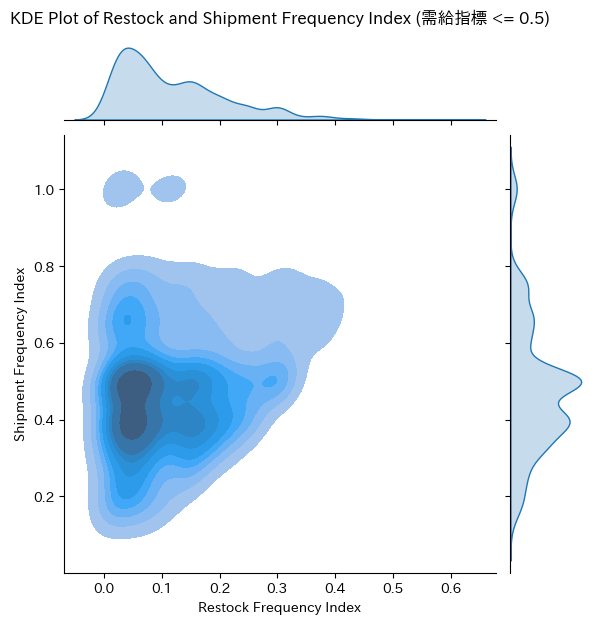

In [ ]:
# 条件に基づいて行をフィルタリング
filtered_df = df[(df['Cost_of_the_Product'] >= 90) &
                     (df['Cost_of_the_Product'] <= 180) &
                     (df['需給指標'] <= 0.5)]

# Seabornのjointplotを使ってカーネル密度推定を描画
sns.jointplot(
    x='Restock_Frequency_Index', y='Shipment_Frequency_Index',
    data=filtered_df, kind='kde', fill=True
)
plt.xlabel('Restock Frequency Index')
plt.ylabel('Shipment Frequency Index')
plt.title('KDE Plot of Restock and Shipment Frequency Index (需給指標 <= 0.5)', pad=80)
plt.show()

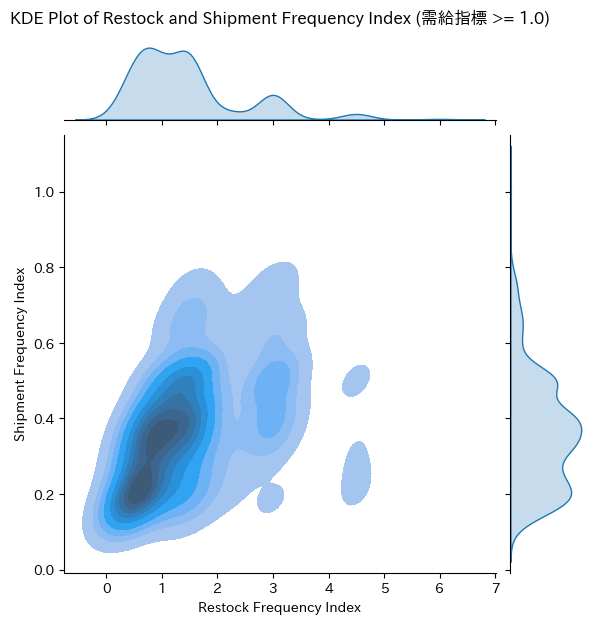

In [ ]:
# 条件に基づいて行をフィルタリング
filtered_df2 = df[(df['Cost_of_the_Product'] >= 90) &
                     (df['Cost_of_the_Product'] <= 180) &
                     (df['需給指標'] >= 1.0)]

# Seabornのjointplotを使ってカーネル密度推定を描画
sns.jointplot(
    x='Restock_Frequency_Index', y='Shipment_Frequency_Index',
    data=filtered_df2, kind='kde', fill=True
)
plt.xlabel('Restock Frequency Index')
plt.ylabel('Shipment Frequency Index')
plt.title('KDE Plot of Restock and Shipment Frequency Index (需給指標 >= 1.0)', pad=80)
plt.show()

In [ ]:
# Restock_Frequency_IndexとShipment_Frequency_Indexの調整
adjusted_df = filtered_df.copy()
adjusted_df['Adjusted_Restock_Frequency_Index'] = (filtered_df['Restock_Frequency_Index'] + filtered_df['Shipment_Frequency_Index']) / 2
adjusted_df['Adjusted_Shipment_Frequency_Index'] = adjusted_df['Adjusted_Restock_Frequency_Index']

# 結果を表示
adjusted_df_display = adjusted_df[['需給指標', 'Restock_Frequency_Index', 'Shipment_Frequency_Index', 'Adjusted_Restock_Frequency_Index', 'Adjusted_Shipment_Frequency_Index']]

print(adjusted_df_display)

           需給指標  Restock_Frequency_Index  Shipment_Frequency_Index  \
0      0.157392                 0.034091                  0.200000   
8      0.197359                 0.054545                  0.250000   
9      0.153165                 0.041379                  0.250000   
14     0.160773                 0.034884                  0.200000   
19     0.064539                 0.026667                  0.400000   
...         ...                      ...                       ...   
10885  0.356675                 0.171429                  0.400000   
10892  0.194156                 0.085714                  0.400000   
10896  0.139762                 0.060000                  0.400000   
10913  0.215111                 0.120000                  0.500000   
10998  0.318454                 0.250000                  0.666667   

       Adjusted_Restock_Frequency_Index  Adjusted_Shipment_Frequency_Index  
0                              0.117045                           0.117045  
8    

調整を行うことで、在庫補填指数と出荷指数を、それぞれどの程度調整する必要があるかを確認します。

In [ ]:
# 増加・減少の割合を計算
restock_increase_percentage = ((adjusted_df['Adjusted_Restock_Frequency_Index'] - filtered_df['Restock_Frequency_Index']) / filtered_df['Restock_Frequency_Index']).mean() * 100
shipment_decrease_percentage = ((filtered_df['Shipment_Frequency_Index'] - adjusted_df['Adjusted_Shipment_Frequency_Index']) / filtered_df['Shipment_Frequency_Index']).mean() * 100

print(f"Restock_Frequency_Indexが平均して{restock_increase_percentage:.2f}%増加しました。")
print(f"Shipment_Frequency_Indexが平均して{shipment_decrease_percentage:.2f}%減少しました。")

Restock_Frequency_Indexが平均して384.44%増加しました。
Shipment_Frequency_Indexが平均して37.20%減少しました。


打ち手仮説2の検証では、在庫補填を平均約3.84倍し、出荷を平均約3.7割絞ることで、需給を改善(需給指標=1)するという設定とします。

施策後の効果をモデルを用いて予測するため、コストが90~180ドルで、「需給指標」が0.5以下の製品の需給指標を1.0に改善します。

In [ ]:
# 条件に基づいて行をフィルタリング
filtered_df = X_test[(X_test['Cost_of_the_Product'] >= 90) &
                     (X_test['Cost_of_the_Product'] <= 180) &
                     (X_test['需給指標'] <= 0.5)]

# 選択された行の 需給指標 の値を 1.0 に書き換える
X_test3 = X_test.copy()
X_test3.loc[filtered_df.index, '需給指標'] = 1.0

# 結果を確認
print(X_test3.loc[filtered_df.index])

       Warehouse_block  Mode_of_Shipment  Customer_care_calls  \
6606                 3                 2                    4   
8749                 4                 1                    4   
1851                 1                 2                    3   
8151                 1                 2                    4   
2514                 3                 2                    4   
...                ...               ...                  ...   
1020                 3                 2                    3   
705                  1                 2                    2   
1419                 1                 2                    4   
1558                 2                 2                    2   
10317                1                 2                    2   

       Cost_of_the_Product  Prior_purchases  Product_importance  Gender  \
6606                   138                3                   2       0   
8749                   133                3                   2      

In [ ]:
y_pred3 = model.predict(X_test3)
y_pred3_binary = (y_pred3 >=  0.6823509949064244).astype(int)

<Axes: >

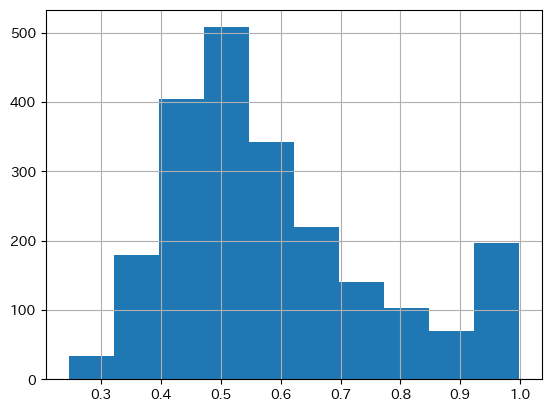

In [ ]:
df_1['pred3']= y_pred3
df_1['pred3'].hist()

In [ ]:
# 2値のカウント
unique, counts = np.unique(y_pred3_binary, return_counts=True)
count_dict = dict(zip(unique, counts))
print(count_dict)

{0: 1652, 1: 548}


施策後、作成したモデルが予測した遅延件数が243件減少(1391件中)→**約17.4％**の遅延が改善することが分かります。（791-548=243, 243/1391=17.4%）

In [ ]:
# 条件でフィルタリング
filtered_df = df2[(df2['Cost_of_the_Product'] >= 90) &
                  (df2['Cost_of_the_Product'] <= 180) &
                  (df2['需給指標'] <= 0.5)]

# ユニークな組み合わせの数（製品数）を確認
unique_combinations_filtered = filtered_df[['Cost_of_the_Product', '需給指標']].drop_duplicates().shape[0]

# 割合を計算
percentage = (unique_combinations_filtered / total_unique_combinations) * 100

print(f"改善した製品の数: {unique_combinations_filtered}")
print(f"改善した製品の割合: {percentage:.2f}%")

改善した製品の数: 1763
改善した製品の割合: 20.80%


全製品8477製品の内、20.8%の製品の需給を改善することで、17.4％の遅延がが改善されることが予測されました。

**打ち手仮説検証のまとめ**


*   **打ち手仮説1**：全8477製品の内、**46.2%**の製品の需給を改善することで、**26.8％**の遅延が改善される
*   **打ち手仮説2**：全8477製品の内、**20.8%**の製品の需給を改善することで、**17.4％**の遅延がが改善される

上記より、打ち手仮説2の方がより少ない製品（打ち手仮説1の半数以下）へのアプローチで、2割弱の遅延が改善されることから、打ち手仮説1と比較して、より効率が高いといえそうです。

# 7.最後に

**まとめ：**


今回は、EC企業の配送データから、需給バランスの悪い製品が配送遅延を引き起こしているという仮説に基づき、需給バランスを改善することで、配送遅延を改善する事業提案について考えました。

このノートブックでは主に、


1.   市場分析とEDAによりデータセットの背景・概要を把握
2.   課題仮説を立て、その根拠づけの市場分析やEDAを行う
3.   課題仮説を根拠づける新しい特徴量を既存カラムを用いて作成
4.   打ち手仮説を立て、事業提案の具体性に繋がるEDAを行う
5.   機械学習モデルを作成し、事業提案の定量評価を行う

を行い、

業界全体として製品需給のバランスが崩れている状況下において、優先順位をつけて遅延改善する方策として、打ち手仮説2のほう効率が高く有効であり、またそれにより、効率的に顧客評価の改善にも繋げられるであろう、ということが分かりました。

このノートブックは最終課題への取り組み方の導入的な位置づけのため、
今後以下のようなポイントを考慮し、改善していくことが考えられます。

**今後の改善ポイント：**


*   より広範又は信頼性の高い情報にあたって市場分析を行い、課題仮説の立案や裏付けに繋げ、説得力を増していく
*   目的変数を'Reached.on.Time_Y.N'以外に設定してみる
  *   "Customer_rating"に設定することで、遅延改善と顧客評価の関係性を確認してみる
  *   ※遅延改善と顧客評価向上の関係について興味のある方は**因果推論パート**をご参照下さい
*   打ち手仮説の需給改善の設定をより具体的にしてみる
  *  需給改善のターゲットとする製品をより特定して検証してみる
  *  企業側から生産の観点から「在庫補填の改善率の上限は200％」という与件が設定されている、などの前提を作ってみる（その場合の出荷減の割合を確認してみるなど）
*   定量評価を遅延改善率ではなく、減収分、増収分を推定して、コストで評価してみる
*   'Reached.on.Time_Y.N'を予測するモデルの精度を上げる

